In [8]:
import pandas as pd
import tensorflow as tf
import os
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [30]:
# === Fonction de chargement des images
def load_image(filename, label):
    img_path = tf.strings.join([IMG_DIR, filename], separator=os.sep)
    img = tf.io.read_file(img_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, IMG_SIZE)
    img = img / 255.0
    return img, label

# === Dataset TF
def build_dataset(df, shuffle=True):
    ds = tf.data.Dataset.from_tensor_slices((df["image"].values, df["label"].values))
    ds = ds.map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
    if shuffle:
        ds = ds.shuffle(500)
    return ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# === Fonction de prédiction sur une image
def predict_image(filename, true_label):
    path = os.path.join(IMG_DIR, filename)
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (224, 224))
    img = img / 255.0
    img = tf.expand_dims(img, axis=0)  # batch size = 1

    pred = model.predict(img, verbose=0)
    pred_label_idx = tf.argmax(pred[0]).numpy()
    pred_label = class_names[pred_label_idx]
    true_label = class_names[true_label]

    # Affichage
    plt.imshow(tf.squeeze(img))
    plt.title(f"Prédit : {pred_label} | Vrai : {true_label}")
    plt.axis("off")
    plt.show()

In [2]:
CSV_PATH = "../dataset/frames_labels.csv"
IMG_DIR = "../dataset/animals_emotions/frames"
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

In [3]:
df = pd.read_csv(CSV_PATH)

In [4]:
df.head()

,image,animal,emotion
0,horse_hunger_01_014.jpg,horse,hunger
1,bird_joy_02_016.jpg,bird,joy
2,bird_joy_02_002.jpg,bird,joy
3,dog_hunger_01_004.jpg,dog,hunger
4,dog_hunger_01_010.jpg,dog,hunger


In [9]:
image_name = random.choice(os.listdir(IMG_DIR))
image_path = os.path.join(IMG_DIR, image_name)

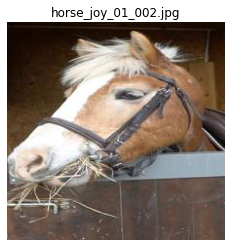

In [10]:
img = mpimg.imread(image_path)
plt.imshow(img)
plt.title(image_name)
plt.axis("off")
plt.show()

In [20]:
label_encoder = LabelEncoder()
df["label"] = label_encoder.fit_transform(df["emotion"])
class_names = label_encoder.classes_

In [21]:
class_names

array(['fear', 'hunger', 'joy'], dtype=object)

In [22]:
train_df, test_df = train_test_split(df, test_size=0.2, stratify=df["label"], random_state=42)

In [23]:
train_ds = build_dataset(train_df)
test_ds = build_dataset(test_df, shuffle=False)

In [24]:
model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(*IMG_SIZE, 3)),
    tf.keras.layers.Conv2D(32, 3, activation="relu"),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(64, 3, activation="relu"),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dense(len(class_names), activation="softmax")
])

In [25]:
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 111, 111, 32)     0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 186624)            0         
                                                                 
 dense_2 (Dense)             (None, 64)               

In [26]:
history = model.fit(train_ds, validation_data=test_ds, epochs=10)

Epoch 1/10
10/10 [==============================] - 8s 733ms/step - loss: 2.4018 - accuracy: 0.5016 - val_loss: 0.7544 - val_accuracy: 0.5844
Epoch 2/10
10/10 [==============================] - 7s 742ms/step - loss: 0.4178 - accuracy: 0.8469 - val_loss: 0.1483 - val_accuracy: 0.9870
Epoch 3/10
10/10 [==============================] - 7s 725ms/step - loss: 0.0599 - accuracy: 0.9935 - val_loss: 0.0409 - val_accuracy: 1.0000
Epoch 4/10
10/10 [==============================] - 7s 727ms/step - loss: 0.0061 - accuracy: 1.0000 - val_loss: 0.0687 - val_accuracy: 0.9481
Epoch 5/10
10/10 [==============================] - 7s 719ms/step - loss: 0.0063 - accuracy: 1.0000 - val_loss: 0.0033 - val_accuracy: 1.0000
Epoch 6/10
10/10 [==============================] - 7s 720ms/step - loss: 0.0020 - accuracy: 1.0000 - val_loss: 0.0024 - val_accuracy: 1.0000
Epoch 7/10
10/10 [==============================] - 7s 724ms/step - loss: 2.4541e-04 - accuracy: 1.0000 - val_loss: 0.0035 - val_accuracy: 1.0000
Ep

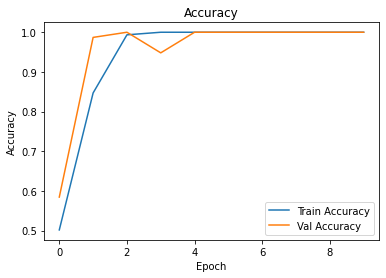

In [28]:
# === Accuracy
plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Val Accuracy")
plt.title("Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

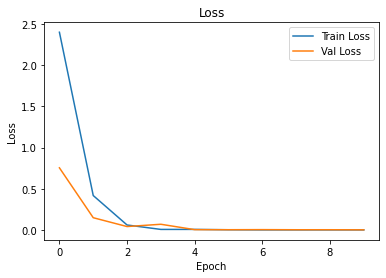

In [29]:
# === Loss
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Val Loss")
plt.title("Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

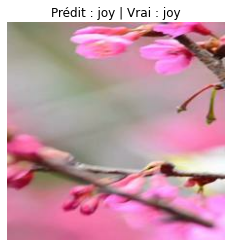

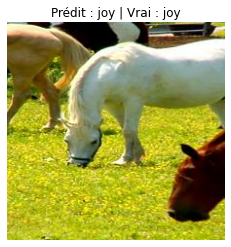

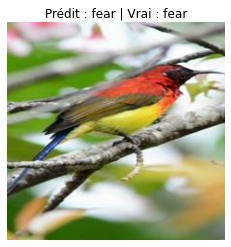

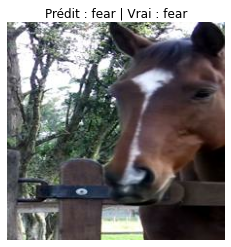

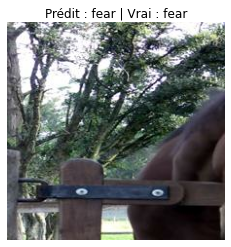

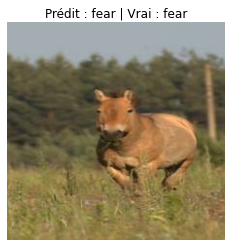

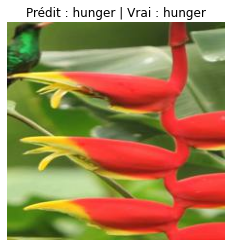

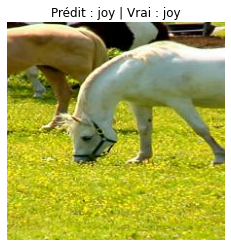

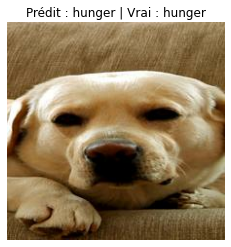

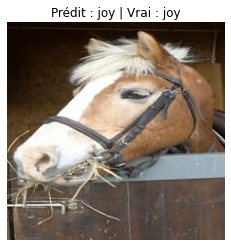

In [31]:
for i in range(10):
    row = test_df.sample(1).iloc[0]
    predict_image(row["image"], row["label"])